<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from IPython.display import clear_output

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data_all, attrs = fetch_dataset()

images not found, donwloading...


--2023-12-02 11:41:39--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  303K 5m50s
    50K .......... .......... .......... .......... ..........  0%  565K 4m29s
   100K .......... .......... .......... .......... ..........  0%  462K 4m16s
   150K .......... .......... .......... .......... ..........  0%  435K 4m13s
   200K .......... .......... .......... .......... ..........  0%  190M 3m22s
   250K .......... .......... .......... .......... ..........  0%  453K 3m27s
   300K .......... .......... .......... .......... ..........  0%  129M 2m58s
   350K .......... .......... .......... .......... ..........  0%  543K 3m0s
   400K .....

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2023-12-02 11:43:25--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-12-02 11:43:25--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  415K 35s
    50K .......... .......... .......... .......... ..........  0%  828K 26s
   100K .......... .......... .......... .......... ..........  1%  834K 23s
   150K .......... .......... ..........

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
print(data_all.shape)
print(attrs.shape)

(13143, 64, 64, 3)
(13143, 73)


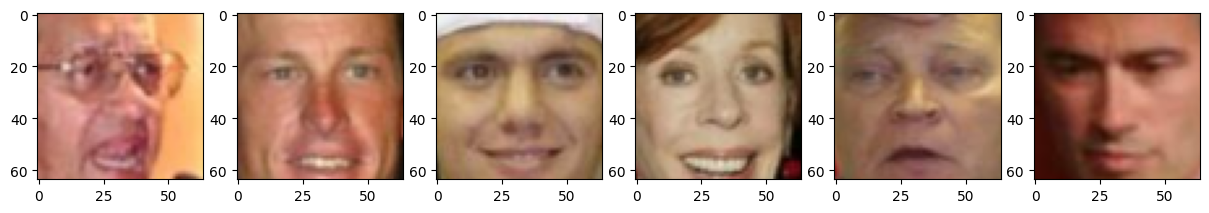

In [ ]:
#  выведем несколько картинок посмотреть с чем на работать )

view_idx = np.random.choice(data_all.shape[0], size=6, replace=False)

to_view = data_all[view_idx]
plt.figure(figsize=(15,6))
for i, img in enumerate(to_view):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img)
    plt.show

Ок, это портреты лиц и кажется довольно известных. Лицо человека занимает почти весь размер фотографии.





In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available()  else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(device)

cuda


In [ ]:
np.random.seed(37) #установим сид для воспроизводимости результатов

idxs = np.random.choice(data_all.shape[0], data_all.shape[0], replace=False) #получим перемешанные индексы

tr, val = np.split(idxs, [int(data_all.shape[0]*0.8)])    #получим индексы для train (80% выборки) и test

data = torch.from_numpy(data_all).permute(0, 3, 1, 2).to(torch.float32) #преобразуем в тензор и переразобьем измерения в привычный формат

X_tr, X_val = data[tr], data[val]  #две выборки для обучения и теста

In [ ]:
print(X_tr.size())
print(X_val.size())
print(X_tr.dtype)
print(X_val.dtype)

torch.Size([10514, 3, 64, 64])
torch.Size([2629, 3, 64, 64])
torch.float32
torch.float32


все ок!

In [ ]:
batch_size = 32

data_tr = DataLoader(X_tr,
                     batch_size=batch_size,
                     shuffle=False)
data_val = DataLoader(X_val,
                      batch_size=batch_size,
                      shuffle=False)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):

        super(Autoencoder, self).__init__()


        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),   # -> 64x64x64 (CxHxW)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,2,stride=2, padding=0),  # -> 128x32x32 (CxHxW)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,2,stride=2, padding=0), #  # -> 256x16x16 (CxHxW)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,2,stride=2, padding=0), #  # -> 256x8x8 (CxHxW)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,512,8,stride=1, padding=0), #  # -> 512x1x1 (CxHxW)
            nn.Flatten()

        )

        # decoder
        self.decoder = nn.Sequential(nn.Linear(512,512),      #решил извратиться и сделать энкодер на свертках а декодер с огромным полносвязным слоем
                                     nn.ReLU(),
                                     nn.Linear(512,12288),
                                     nn.Unflatten(1, (3, 64, 64)),
                                     nn.Sigmoid()
                                     )

            # nn.Unflatten(1, (256, 8, 8)),
            # nn.Conv2d(256,256,3,stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.UpsamplingBilinear2d(16),
            # nn.Conv2d(256,256,3,stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Conv2d(256,128,3,stride=1, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            # nn.UpsamplingBilinear2d(32),
            # nn.Conv2d(128,64,3,stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64,3,3,stride=1, padding=1),
            # nn.UpsamplingBilinear2d(64),
            # nn.Sigmoid()

        # )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [ ]:
mse_loss = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.0001)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
summary(autoencoder,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          32,896
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         131,328
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         262,400
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 1, 1]       8,389,120
          Flatten-14                  [

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, optim, loss_func, num_epochs, data_train, data_val):
    to_show = next(iter(data_val))
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for X_tr in data_train:
            optimizer.zero_grad()
            X_tr = X_tr.to(device)
            reconstruction, latent_code = model(X_tr)
            loss = loss_func(reconstruction, X_tr)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(data_train)
        train_losses.append(average_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_val in data_val:
                X_val = X_val.to(device)
                reconstruction, latent_code = model(X_val)
                loss = loss_func(reconstruction, X_val)

                running_loss += loss.item()

            average_loss = running_loss / len(data_val)
            val_losses.append(average_loss)

        show_val, _ = model(to_show.to(device))


        # Вывод восстановленных картинок
        show_val = show_val.detach().to('cpu')
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(to_show[i].numpy(), 0, 3))
            plt.title('Real Photo')

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(np.rollaxis(show_val[i].numpy(), 0, 3))
            plt.title('Reconstructed Photo')


        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')





        # Построение графика
        plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()




Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Not bad, right?

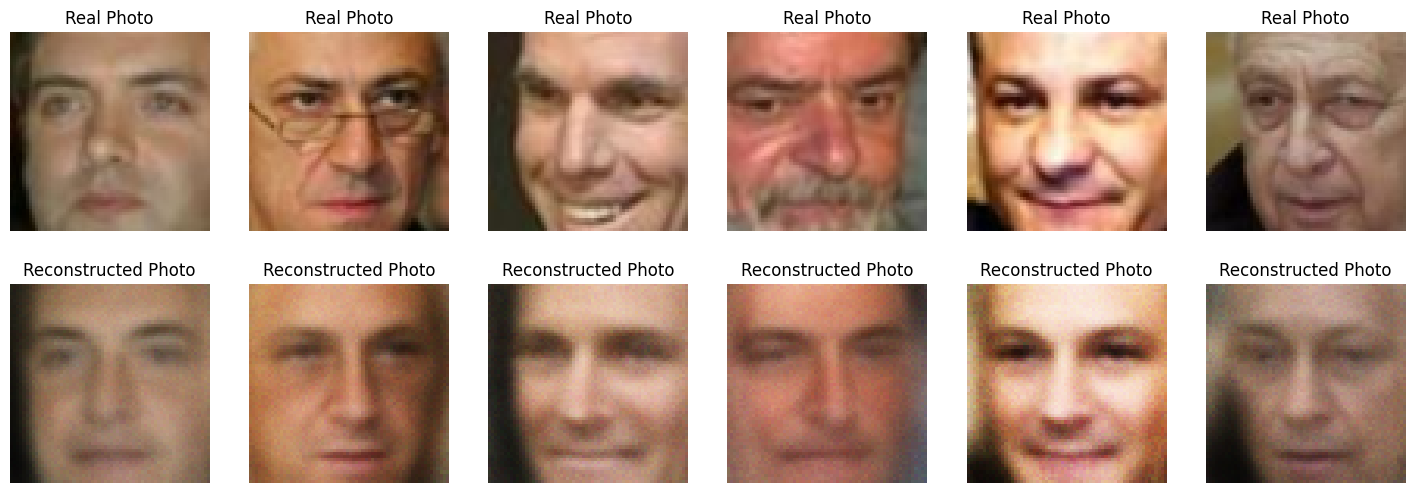

Epoch [10/10], Loss: 0.0044


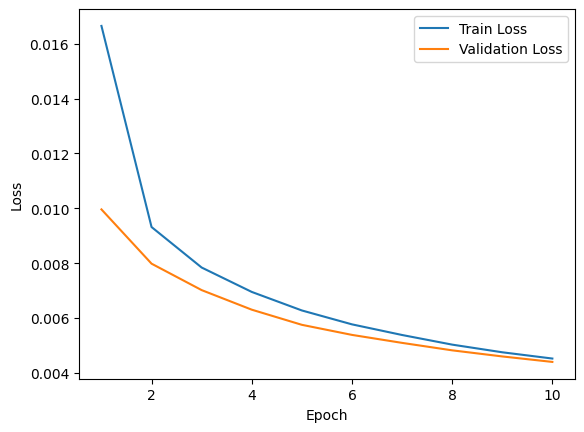

In [ ]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.0001)
train(autoencoder, optimizer, mse_loss, 10, data_tr, data_val)

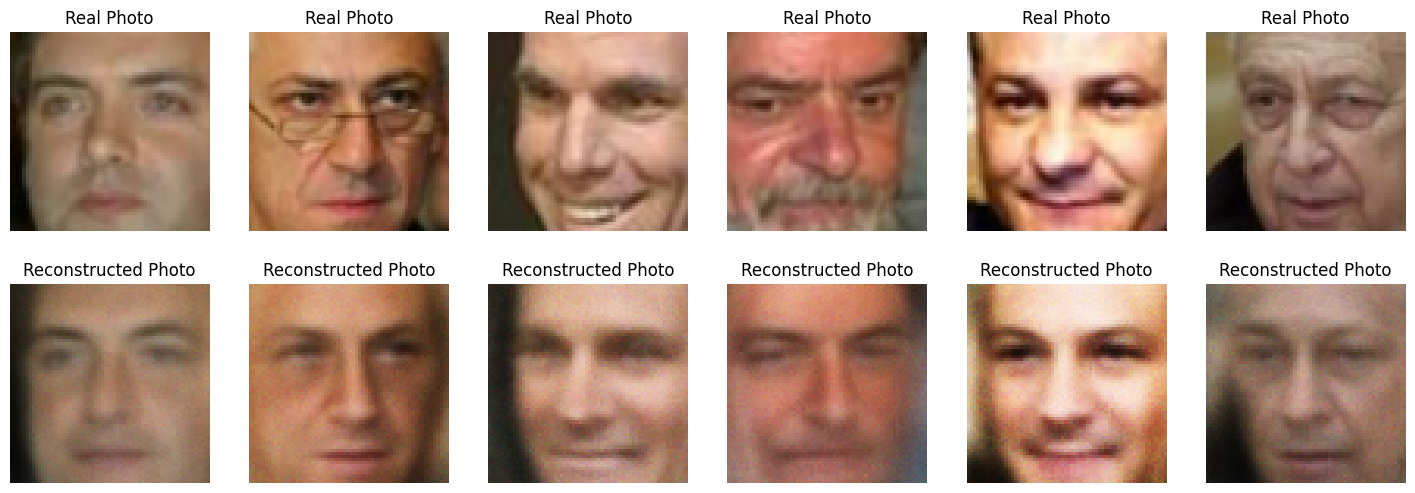

Epoch [5/5], Loss: 0.0038


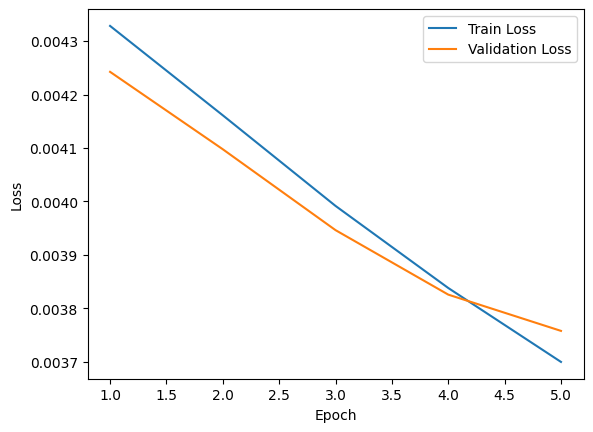

In [ ]:
#еще немного дообучим
train(autoencoder, optimizer, mse_loss, 5, data_tr, data_val)

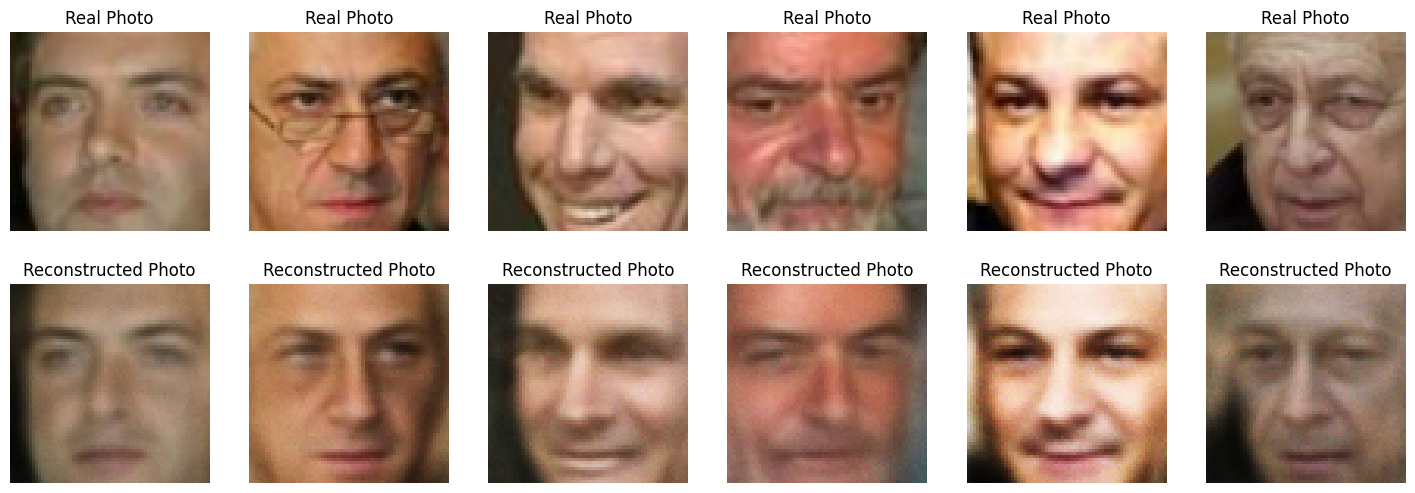

Epoch [5/5], Loss: 0.0028


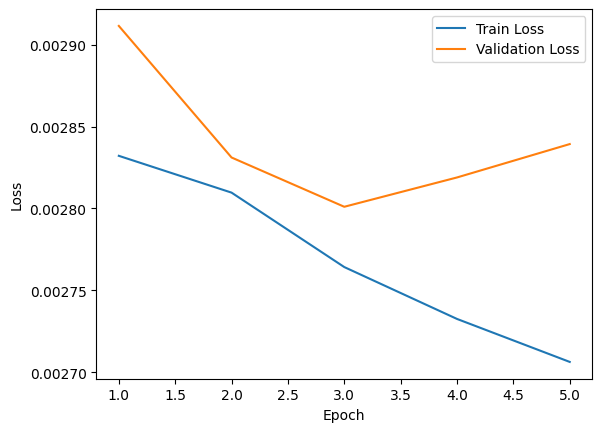

In [ ]:
#и еще немного дообучим
train(autoencoder, optimizer, mse_loss, 5, data_tr, data_val)

Последнюю ячейку я несколько раз еще запускал суммарно все обучение примерно 30 эпох наверное

В целом нормально восстанавливает, понятно что пропадает четкость и некоторые детали

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

Посмотрим что представляет собой латентый вектор

In [ ]:
faces = next(iter(data_val)) #сгенерируем батч лиц

autoencoder.eval()
z = autoencoder.encoder(faces.to(device)).detach().cpu() #получим латентный вектор

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: ylabel='Count'>

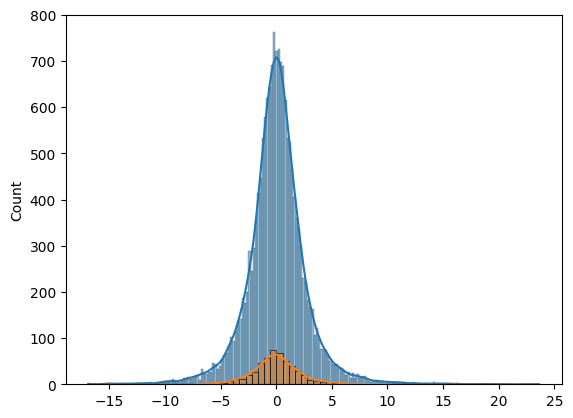

In [ ]:
import seaborn as sns
from scipy.stats import norm
#построим распределения
sns.histplot(z[:,].flatten(), kde=True)

sns.histplot(z[7].flatten(), kde=True)

распределение похоже на нормальное

In [ ]:
mu_all, std_all = norm.fit(z[0:,]) #узнаем параметры распределения всех латентных векторов
mu, std = norm.fit(z[7]) #узнаем параметры распределения случайной картинки
print(mu_all, std_all)
print(mu, std)

0.04177247 2.7046099
0.04607872 2.1822941


<Figure size 1800x1800 with 0 Axes>

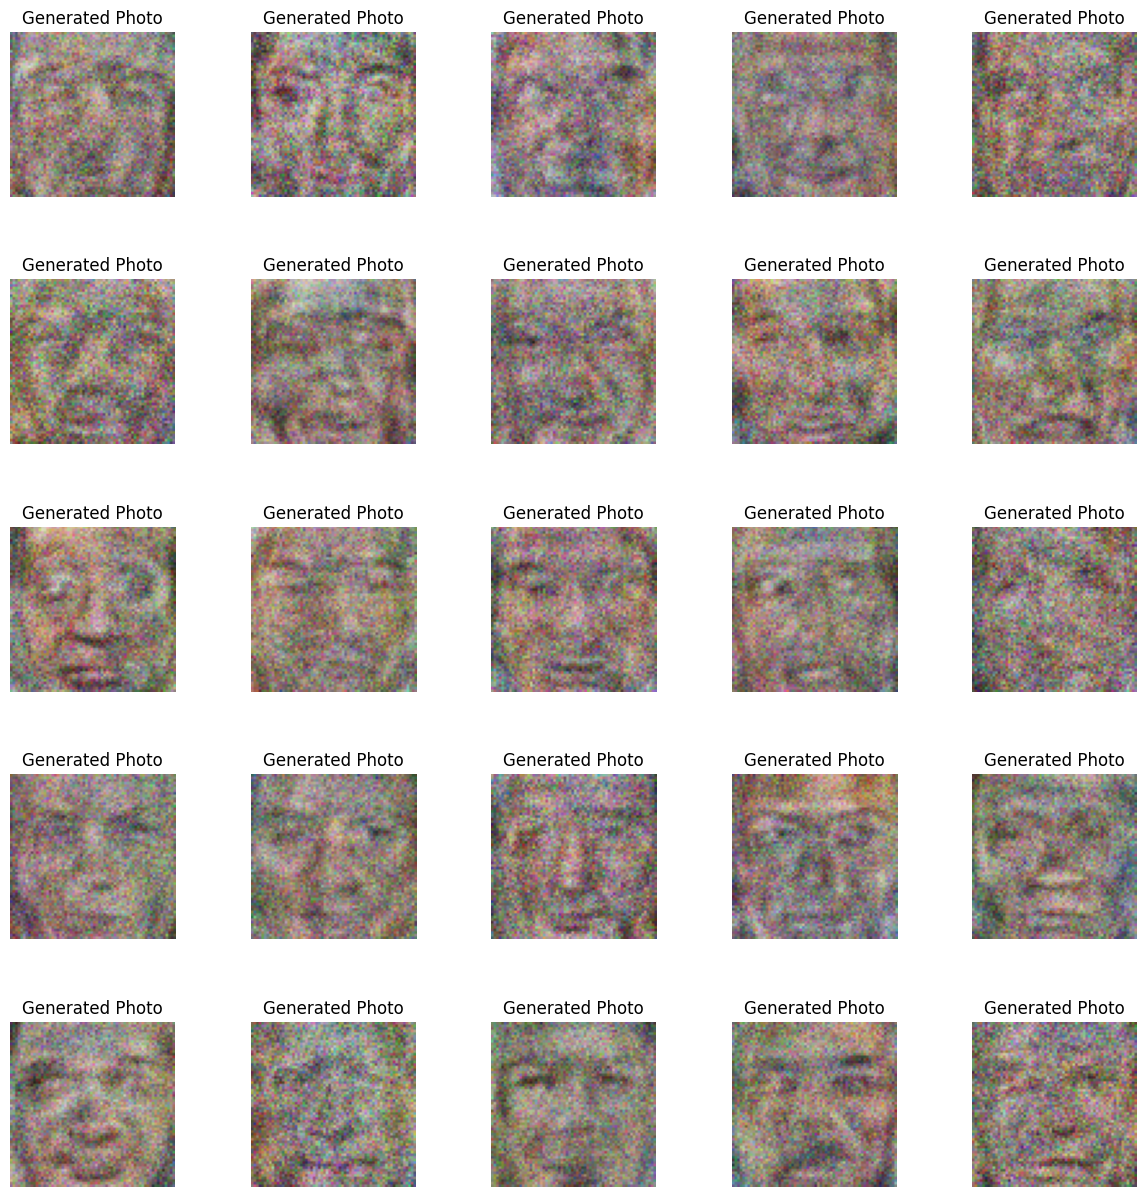

In [ ]:
from IPython.display import display, Image
# сгенерируем 25 рандомных векторов размера latent_space
z = mu_all + torch.randn(25, 512)*std_all
z = z.to(device)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decoder(z).detach().cpu() #сгенерируем изображения


#покажим их
def plot_photos(photos, n = 25):
    plt.figure(figsize=(18, 18))
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5)

    for i in range(n):
        row = i // 5
        col = i % 5

        axs[row, col].axis("off")
        axs[row, col].imshow(np.rollaxis(photos[i].numpy(), 0, 3))
        axs[row, col].set_title('Generated Photo')


    plt.show()

plot_photos(output, 25)

Такое себе) попробуем ниже хитрее сделать случайные латентные вектора

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
autoencoder.eval()
with torch.no_grad():
    z = autoencoder.encoder(X_tr[0:2000].to(device)).detach().cpu() #получим латентные вектора 2000 картинок из трейна

In [ ]:
z.size()

torch.Size([2000, 512])

А теперь посчитаем статистики распределения каждого измерения (фичи) латентного вектора в этих 2000 картинках,
то есть для каждого измерения у нас будет свое $\mu$ и $\sigma$


In [ ]:
mu, std = z.mean(dim=0), z.std(dim=0)

In [ ]:
mu.size()

torch.Size([512])

то что мы и хотели 512 средних и 512 сигм

In [ ]:
random_z = mu.expand(25,-1) + torch.randn((25,512))*std.expand(25,-1)  #сгенерируем случайные вектора на основе стандартных распределений по каждой фиче в латентном векторе

<Figure size 1800x1800 with 0 Axes>

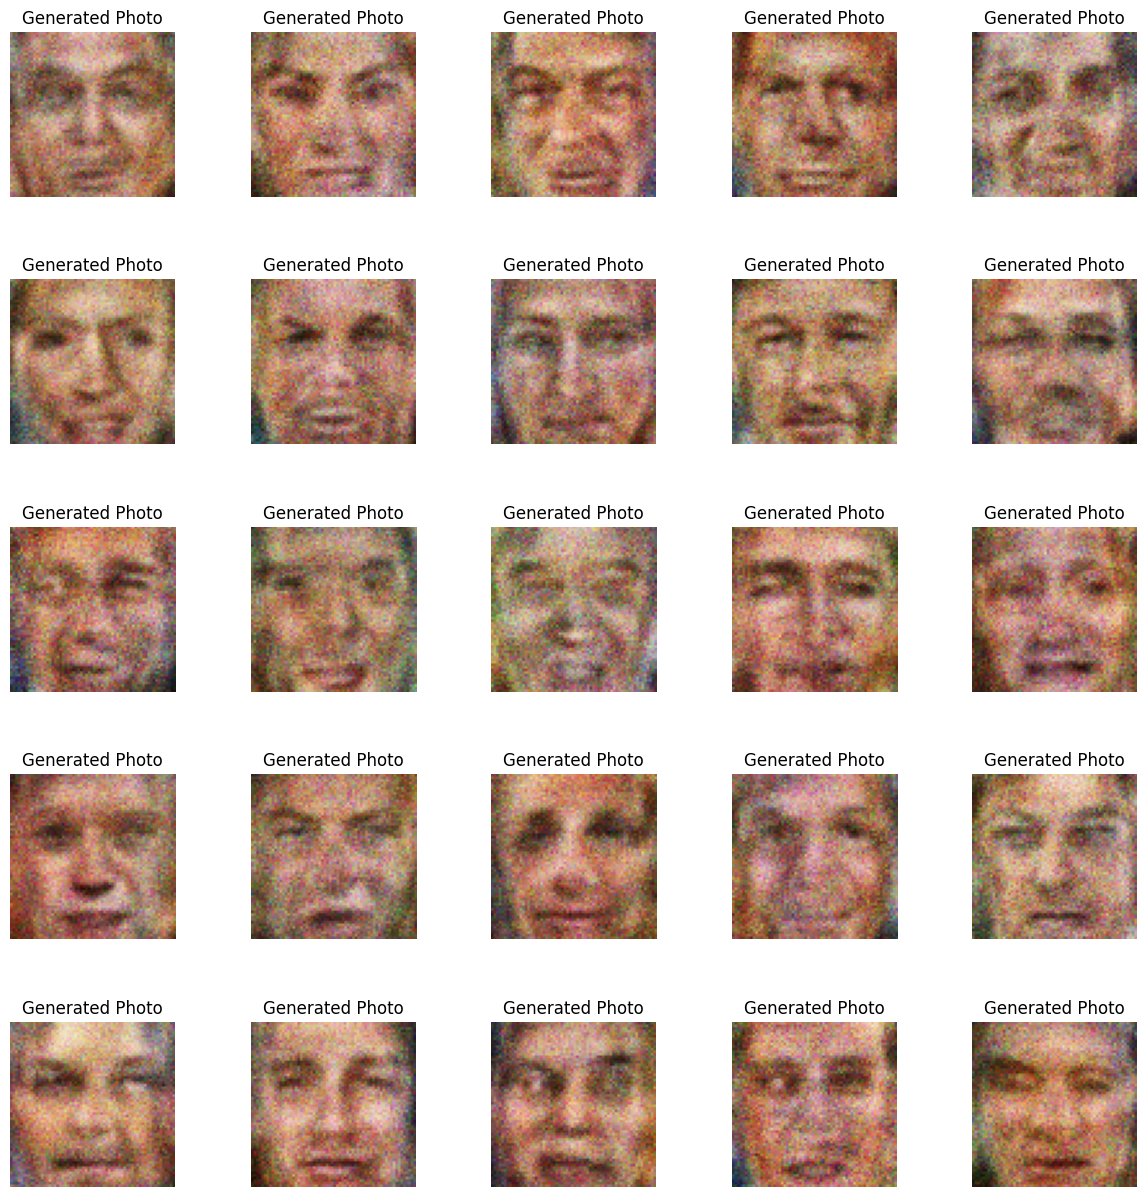

In [ ]:

z = random_z.to(device)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decoder(z).detach().cpu() #сгенерируем изображения


#покажем их
def plot_photos(photos, n = 25):
    plt.figure(figsize=(18, 18))
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5)

    for i in range(n):
        row = i // 5
        col = i % 5

        axs[row, col].axis("off")
        axs[row, col].imshow(np.rollaxis(photos[i].numpy(), 0, 3))
        axs[row, col].set_title('Generated Photo')


    plt.show()

plot_photos(output, 25)

Ну в целом немного стремные, но все-таки лица и это мач беттер чем было с простым нормальным распределением

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

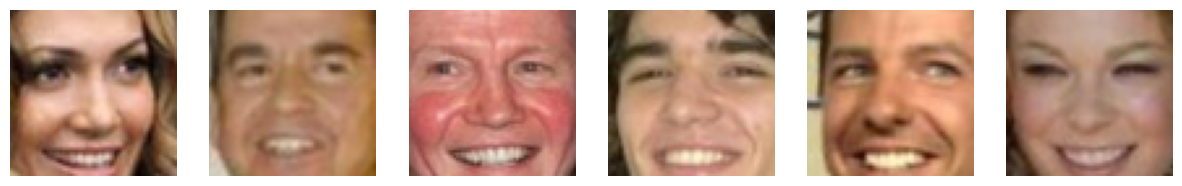

In [ ]:
smiling_idx = attrs['Smiling'] > 2

smiling = data_all[smiling_idx]

#проверим правильно ли мы отобрали веселых

view_idx = np.random.choice(smiling.shape[0], size=6, replace=False)

to_view = smiling[view_idx]
plt.figure(figsize=(15,6))
for i, img in enumerate(to_view):
    plt.subplot(1, 6, i + 1)
    plt.axis("off")
    plt.imshow(img)
    plt.show



улыбаются )))

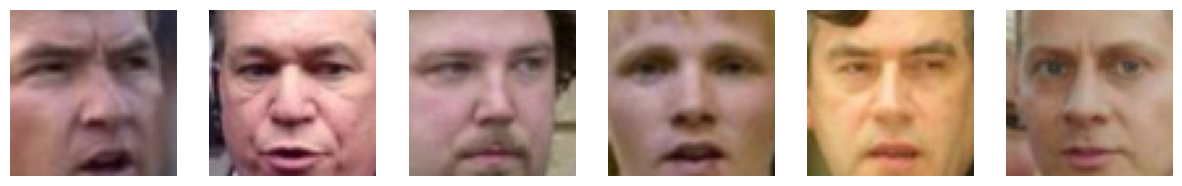

In [ ]:
sad_idx = attrs['Smiling'] < -2

sad = data_all[sad_idx]

# проверим правильно ли мы отобрали приунывших

view_idx = np.random.choice(sad.shape[0], size=6, replace=False)

to_view = sad[view_idx]
plt.figure(figsize=(15,6))
for i, img in enumerate(to_view):
    plt.subplot(1, 6, i + 1)
    plt.axis("off")
    plt.imshow(img)
    plt.show

не улыбаются (

In [ ]:
#выберем рандомно по 15 лиц по улыбкам и сложным щщам которых мы будем вычислять "вектор улыбки", также переведем картинки в тензоры и в нужную размерность
smile = torch.from_numpy(smiling[np.random.choice(smiling.shape[0], size=15, replace=False)]).permute(0, 3, 1, 2).to(torch.float32).to(device)
sad = torch.from_numpy(sad[np.random.choice(sad.shape[0], size=15, replace=False)]).permute(0, 3, 1, 2).to(torch.float32).to(device)

In [ ]:
sad.size()

torch.Size([15, 3, 64, 64])

In [ ]:
# сгенерируем латентные вектора
with torch.no_grad():
        _, smile_latent_vector = autoencoder(smile)
        _, sad_latent_vector = autoencoder(sad)


In [ ]:
delta_smile = smile_latent_vector.mean(dim=0) - sad_latent_vector.mean(dim=0)  #считаем вектор улыбки

In [ ]:
delta_smile.size()

torch.Size([512])

torch.Size([15, 3, 64, 64])


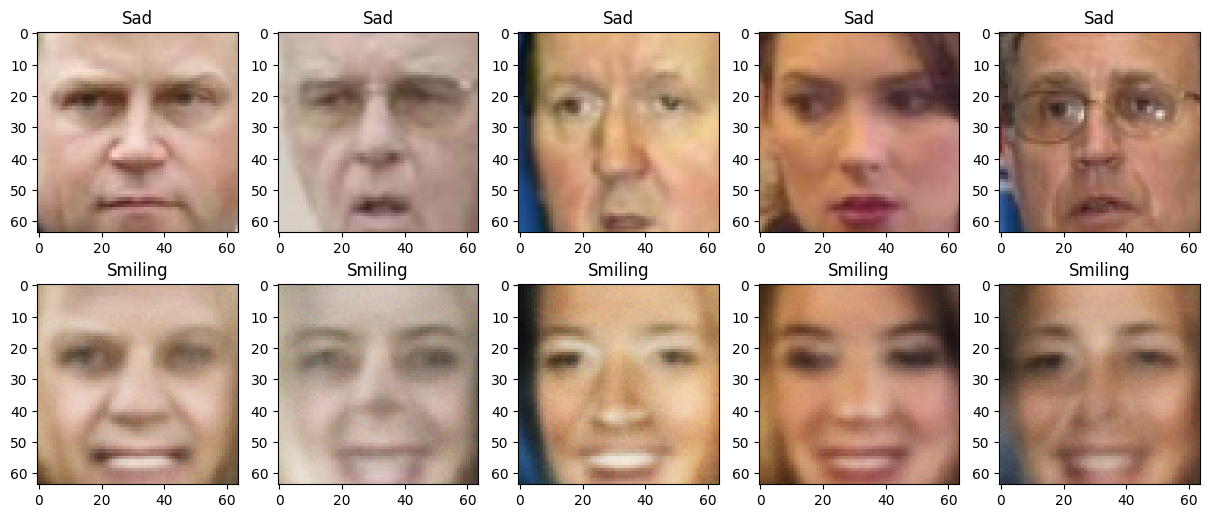

In [ ]:
with torch.no_grad():
    output = autoencoder.decoder(sad_latent_vector+delta_smile).view(-1,3,64,64).detach().cpu() #прибавляем улыбку грустным латентным векторам и генерируем изображения

print(output.size())



plt.figure(figsize=(15,6))


for i, img in enumerate(sad[5:10].cpu().permute(0, 2, 3, 1)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title('Sad')

for i, img in enumerate(output[5:10].permute(0, 2, 3, 1)):
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.title('Smiling')

plt.show()

Ну люди определенно стали более улыбчивыми как доп. бонус у кого то улучшилось зрение и стали моложе выглядеть )))

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import datasets, transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 144440854.94it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 46590651.47it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43081076.65it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8315377.03it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, lspace=64):
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста",
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()
        self.lspace = lspace


        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 2*self.lspace),
            nn.BatchNorm1d(2*self.lspace),
        )




        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.lspace, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )






    def encode(self, x):

        distr_pars = self.encoder(x).view(-1, 2, self.lspace)
        mu = distr_pars[:,0,:]
        logvar = distr_pars[:,1,:]

        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar) # стандартное отклонение
            eps = torch.randn_like(std) # случайное стандартное отклонение из нормального распределения
            sample = mu + (eps * std) # наш сэмпл - латентный вектор
            return sample

        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
#         <реализуйте forward проход декодера
#         в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        mu, logvar = self.encode(x)
        sample = self.gaussian_sampler(mu, logvar)
        reconstruction = self.decode(sample)

        return mu, logvar, reconstruction.view(-1,x.size()[1],x.size()[2],x.size()[3])

In [ ]:
from torchsummary import summary

In [ ]:
v = VAE().to(device)
summary(v,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3          [-1, 128, 14, 14]          73,856
       BatchNorm2d-4          [-1, 128, 14, 14]             256
              ReLU-5          [-1, 128, 14, 14]               0
            Conv2d-6            [-1, 256, 7, 7]         131,328
       BatchNorm2d-7            [-1, 256, 7, 7]             512
              ReLU-8            [-1, 256, 7, 7]               0
           Flatten-9                [-1, 12544]               0
           Linear-10                  [-1, 128]       1,605,760
      BatchNorm1d-11                  [-1, 128]             256
           Linear-12                [-1, 12544]         815,360
      BatchNorm1d-13                [-1, 12544]          25,088
             ReLU-14                [-1

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logvar):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = (-0.5 * (1 + logvar - mu.pow(2) - torch.exp(logvar))).mean() #надо все таки усреднить по длине латентного вектора и по батчу
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='mean')
    return loss(reconstruction, x)

def loss_vae(x, mu, logvar, reconstruction):
    return KL_divergence(mu, logvar)  + log_likelihood(x, reconstruction)

И обучим модель:

немного поменяем первоначальную функцию обучения под новую VAE модель

In [ ]:
def train(model, optimizer, loss_func, num_epochs, data_train, data_val):
    to_show = (next(iter(data_val)))[0]
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for X_tr in data_train:
            optimizer.zero_grad()
            X_tr = X_tr[0].to(device)
            mu, logvar, reconstruction = model(X_tr)
            loss = loss_func(X_tr, mu, logvar, reconstruction )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(data_train)
        train_losses.append(average_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_val in data_val:
                X_val = X_val[0].to(device)
                mu, logvar, reconstruction = model(X_val)
                loss = loss_func(X_val, mu, logvar, reconstruction )

                running_loss += loss.item()

            average_loss = running_loss / len(data_val)
            val_losses.append(average_loss)

            mu, logvar, show_val = model(to_show.to(device))



        show_val = show_val.detach().to('cpu')

        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(to_show[i].squeeze(0).numpy())
            plt.title('Real Photo')

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(show_val[i].squeeze(0).numpy())
            plt.title('Reconstructed Photo')


        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')





        # Построение графика
        plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()




In [ ]:
criterion = loss_vae

vaencoder = VAE(lspace=64).to(device)

optimizer = torch.optim.AdamW(vaencoder.parameters(), lr=0.00005)

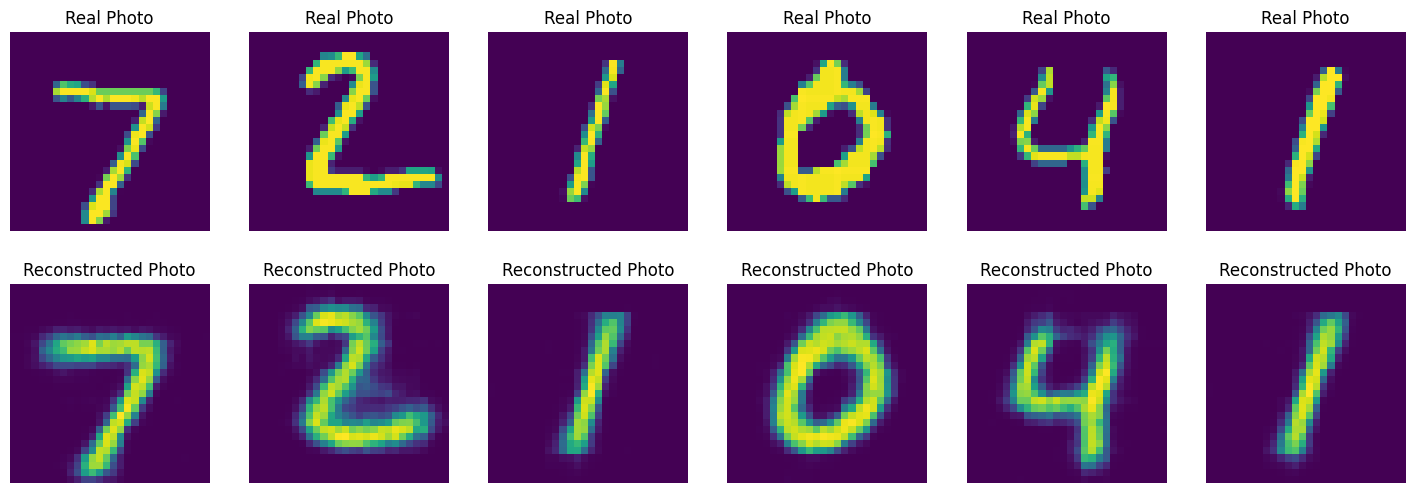

Epoch [5/5], Loss: 0.3297


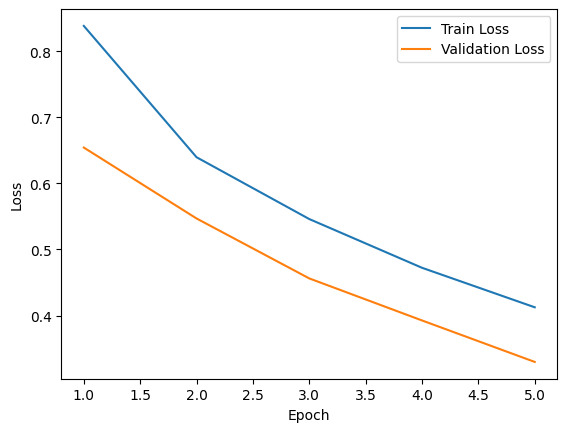

In [ ]:
train(vaencoder, optimizer, criterion, 5, train_loader, test_loader)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Выше это показано как модель восстанавливает картинки из валидации по ходу обучения. Но ниже показано еще несколько картинок из теста

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

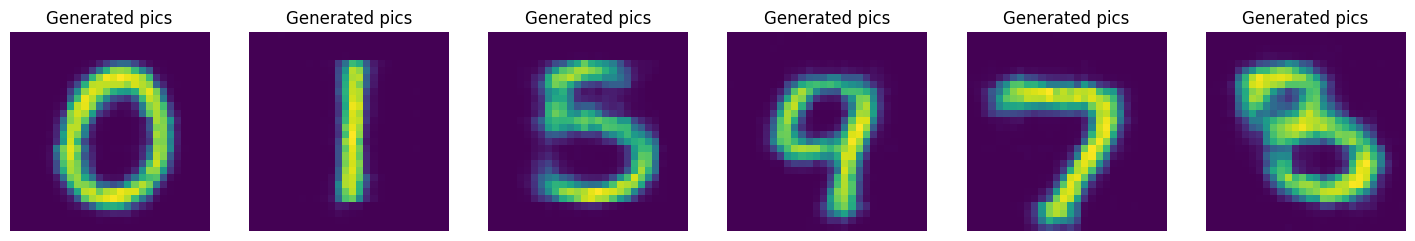

In [ ]:
to_show = (next(iter(test_loader)))[0].to(device) #получаем батч из теста
vaencoder.eval()
z = vaencoder.gaussian_sampler(*vaencoder.encode(to_show))
output = vaencoder.decode(z).detach().to('cpu')

plt.figure(figsize=(18, 6))
for i,j in enumerate(range(13,19)):

    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(output[j].squeeze(0).numpy())
    plt.title('Generated pics')


plt.show()

In [ ]:
z = z.detach().to('cpu')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

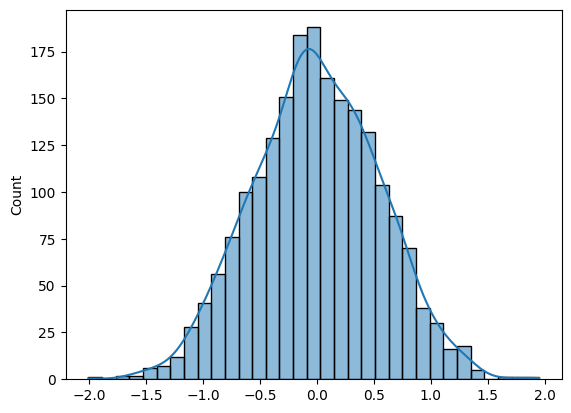

In [ ]:
import seaborn as sns
sns.histplot(z.flatten(),kde=True) #посмотрим распределения латентных векторов после обработки исходных картинок энкодером

In [ ]:
mu, std = norm.fit(z.flatten())
print(mu, std)

-0.0037257583 0.5537739


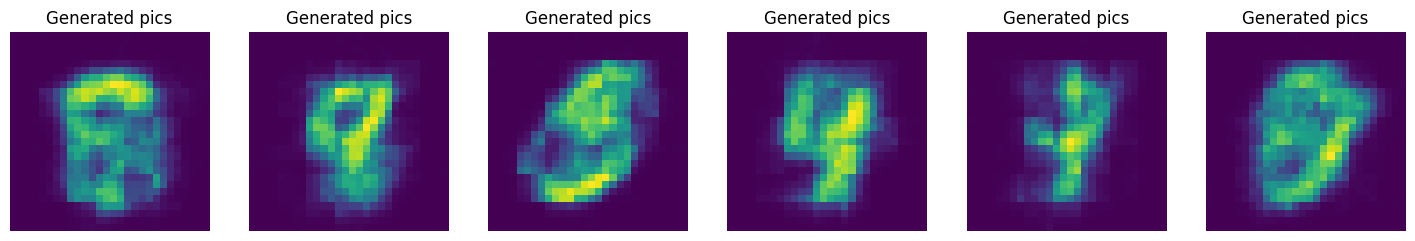

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = (mu + torch.randn(10, 64)*std).to(device)

vaencoder.eval()
output = vaencoder.decode(z).detach().to('cpu')

plt.figure(figsize=(18, 6))
for i in range(6):

    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(output[i].squeeze(0).numpy())
    plt.title('Generated pics')


plt.show()



Ну в общем это какие-то знаки, но не читаемые цифры ))
На мой взгляд логично, что мы должны из случайного распределения получать некие случайные комбинации частей цифр

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

/tmp/ipykernel_47/3175423537.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=10, c=class_colors[label], label=label)


Text(0.5, 1.0, 't-SNE визуализация латентных векторов разделенных по меткам классов')

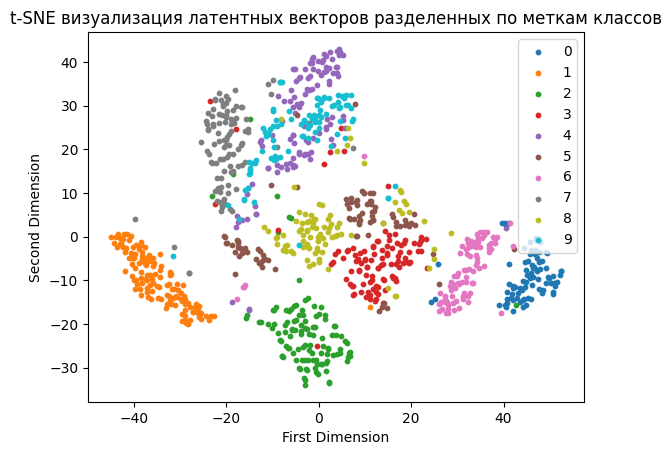

In [ ]:
from sklearn.manifold import TSNE
test_digits = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False) #создаем даталоадер с батчем 1000 картинок которые будем преобразовывать

tsne = TSNE() #инициации TSNE

imgs_labels = (next(iter(test_digits))) #получаем 1000 картинок и их меток

imgs = imgs_labels[0].to(device)
labels = imgs_labels[1].numpy()

labels_unique = np.unique(labels) #уникальные метки - цифры 0-9

vaencoder.eval()
z = vaencoder.gaussian_sampler(*vaencoder.encode(imgs)).detach().to('cpu').numpy() #получаем латентные вектора наших картинок

tsne_repr = tsne.fit_transform(z) #обучаем TSNE и трансформируем наши латентные вектора

#готовим карту цветов

colors = plt.get_cmap('tab10').colors

num_classes = len(labels_unique)

class_colors = dict(zip(range(num_classes), colors))

#строим scatter-plot наших латентных векторов после их переноса в двумерное пространство
for label in labels_unique:
    mask = labels == label
    plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=10, c=class_colors[label], label=label)

plt.legend()


plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE визуализация латентных векторов разделенных по меткам классов')



Что вы думаете о виде латентного представления?

TSNE визуализация выглядит довольно логично - "облака" цифр очень отличных внешне друг от друга например (0 и другие цифры)(1 и 2) находятся далеко и не пересекаются. А "облака" похожих цифр находятся рядом друг с другом например 3, 8, 5. Также видно что 4 и 9 объективно очень похожие по форме (если сверху четверки прибавить горизонтальную линию то получится девятка), их облака немного наложены друг на друга. Хуже всего распределены 5-ки, у них нет четкого "облака" и их TSNE представление сильно разрежено.



__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, lspace=64):
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста",
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        self.lspace = lspace


        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28+10, 784),   #сделаем линейный слой и вернемя к размерности 28*28 далее та же модлеь что и в VAE
            nn.Unflatten(1, (1,28,28)),
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 2*self.lspace),
            nn.BatchNorm1d(2*self.lspace),
        )




        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.lspace+10, 256 * 7 * 7),   #к латентному вектору добавим еще ohe-вектор метки у него размерность 10 так как 10 классов
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )






    def encode(self, x):

        distr_pars = self.encoder(x).view(-1, 2, self.lspace)
        mu = distr_pars[:,0,:]
        logvar = distr_pars[:,1,:]

        return mu, logvar

    def gaussian_sampler(self, mu, logvar, class_num):
        ohe_labels = nn.functional.one_hot(class_num, num_classes=10) #ohe для меток
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return torch.cat([sample,ohe_labels],dim=1) #соединим латентный вектор с вектором ohe

        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return torch.cat([mu,ohe_labels],dim=1)

    def decode(self, z):
#         <реализуйте forward проход декодера
#         в качестве возвращаемой переменной -- reconstruction>

        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        ohe_labels = nn.functional.one_hot(class_num, num_classes=10) #метки закодируем в ohe
        mu, logvar = self.encode(torch.cat([torch.flatten(x,1,-1),ohe_labels],dim=1)) #метки объеденим с "распрямленными" картинками
        sample = self.gaussian_sampler(mu, logvar,class_num)
        reconstruction = self.decode(sample)

        return mu, logvar, reconstruction.view(-1,x.size()[1],x.size()[2],x.size()[3])

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

Обучим нашу CVAE архитектуру

Немного новая функция train под CVAE

In [ ]:
def train(model, optimizer, loss_func, num_epochs, data_train, data_val):
    to_show = (next(iter(data_val)))
    imgs, labels = to_show[0], to_show[1]
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for X_tr in data_train:
            optimizer.zero_grad()
            X_img_tr = X_tr[0].to(device) #картинки
            X_lab_tr = X_tr[1].to(device) #метки
            mu, logvar, reconstruction = model(X_img_tr,X_lab_tr)
            loss = loss_func(X_img_tr, mu, logvar, reconstruction )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(data_train)
        train_losses.append(average_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_val in data_val:
                X_img_val = X_val[0].to(device)
                X_lab_val = X_val[1].to(device)
                mu, logvar, reconstruction = model(X_img_val,X_lab_val)
                loss = loss_func(X_img_val, mu, logvar, reconstruction )

                running_loss += loss.item()

            average_loss = running_loss / len(data_val)
            val_losses.append(average_loss)

            mu, logvar, show_val = model(imgs.to(device),labels.to(device))



        show_val = show_val.detach().to('cpu')

        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(imgs[i].squeeze(0).numpy())
            plt.title('Real Photo')

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(show_val[i].squeeze(0).numpy())
            plt.title('Reconstructed Photo')


        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')





        # Построение графика
        plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()




In [ ]:
criterion = loss_vae

cvaencoder = CVAE(lspace=64).to(device)

optimizer = torch.optim.AdamW(cvaencoder.parameters(), lr=0.00005)

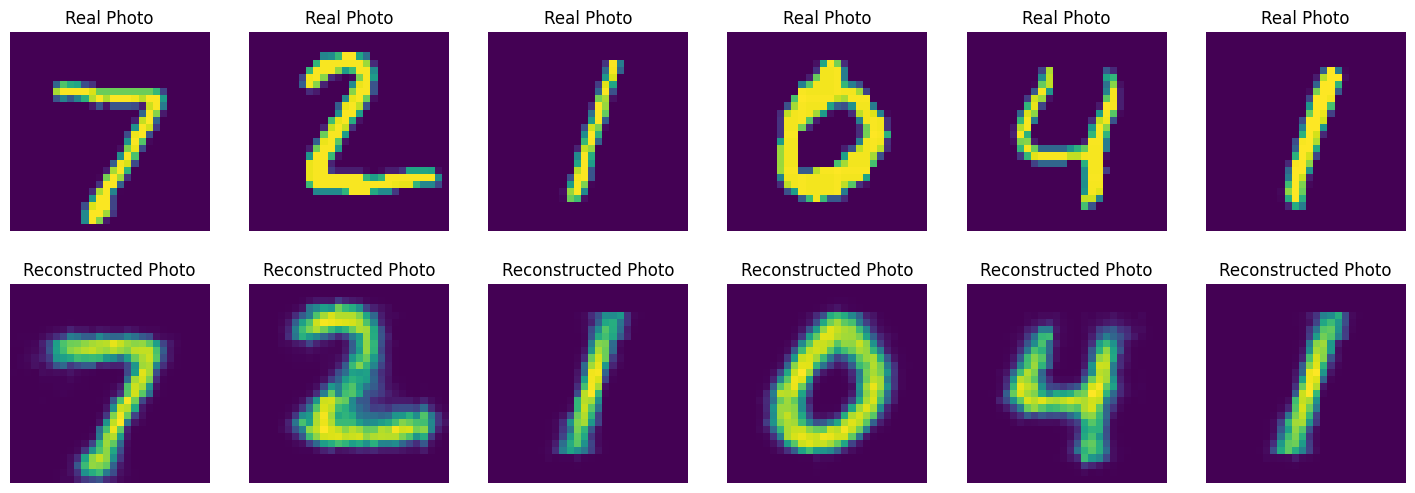

Epoch [8/8], Loss: 0.2149


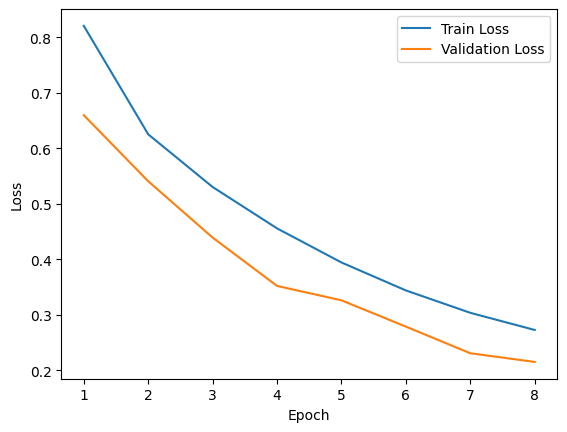

In [ ]:
train(cvaencoder, optimizer, criterion, 8, train_loader, test_loader)

Восстановление кажется идет даже лучше

Посмотрим распределение латентных векторов чтобы генерировать похожие

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

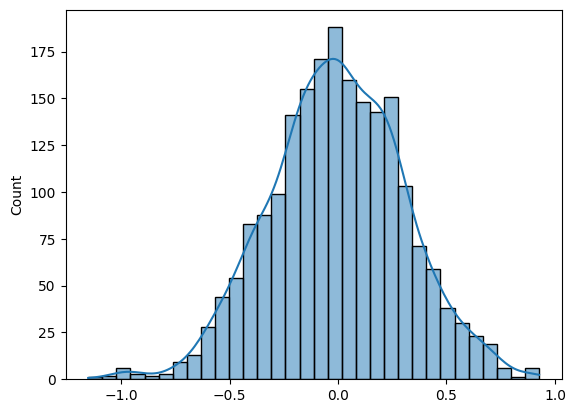

In [ ]:
imgs_labels = (next(iter(test_loader)))

imgs, labels = imgs_labels[0].to(device), imgs_labels[1].to(device)
cvaencoder.eval()

ohe_labels = nn.functional.one_hot(labels, num_classes=10)

z = cvaencoder.gaussian_sampler(*cvaencoder.encode(torch.cat([torch.flatten(imgs,1,-1),ohe_labels],dim=1)),labels)

z = z.detach().to('cpu')[:,:-10] #отсечем лейблы так как нам надо посмотреть на распределение латентного вектора картинки до конкатенации с лейблами перед декодером

sns.histplot(z.flatten(),kde=True)

In [ ]:
mu, std = norm.fit(z.flatten())
print(mu, std)

-0.004405246 0.3088639


Попробуем сгенерировать

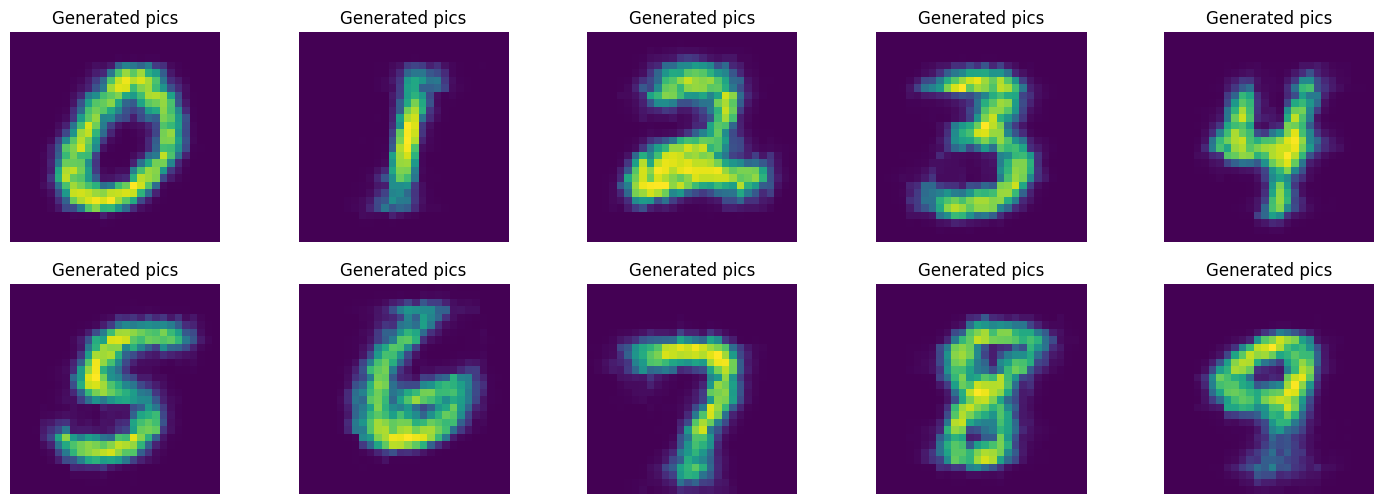

In [ ]:
z = (mu + torch.randn(10, 64)*std).to(device)  #генерируем 10 латентных векторов

labels = nn.functional.one_hot(torch.arange(0, 10), num_classes=10).to(device) #генерируем 10 ohe-закодированных меток от 0 до 9

z = torch.cat([z,labels],dim=1) #объединяем и подаем на конкатенацию

cvaencoder.eval()
output = cvaencoder.decode(z).detach().to('cpu') #генерируем наши 10 изображений цифр

#строим
plt.figure(figsize=(18, 6))
for i in range(5):

    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output[i].squeeze(0).numpy())
    plt.title('Generated pics')

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(output[i+5].squeeze(0).numpy())
    plt.title('Generated pics')


plt.show()

Приемлемо )))) в целом видно, что как мы и просили, сгенерировались читаемые цифры от 0 до 9. Причем каждая сгенерированная цифра соответствует запрошенному классу классу

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

/tmp/ipykernel_47/3504037223.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=10, c=class_colors[label], label=label)


Text(0.5, 1.0, 't-SNE визуализация латентных векторов разделенных по меткам классов')

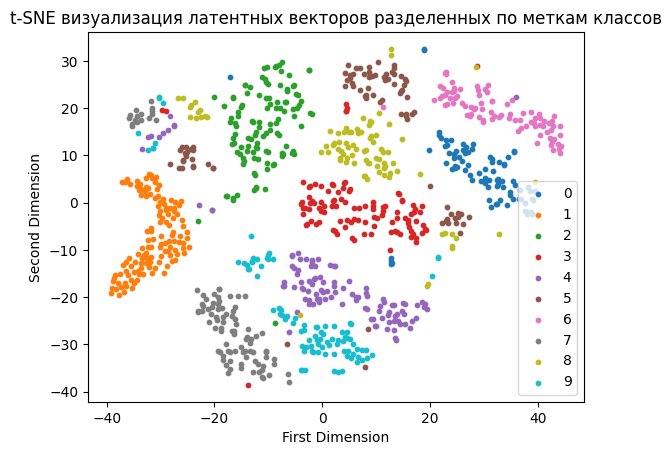

In [ ]:
test_digits = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False) #создадим  лоадер с батчем в 1000 картинок

tsne = TSNE() #иницируем преобразование TSNE

imgs_labels = (next(iter(test_digits))) #получим "батч" из 1000 картинок латентные вектора которых будем преобразовывать в двумерное пространство

imgs = imgs_labels[0].to(device) #картинки тензор
labels_ = imgs_labels[1].to(device) #лейблы тензор

labels = imgs_labels[1].numpy() #лейблы в numpy

labels_unique = np.unique(labels) # цифры 0-9

ohe_labels = nn.functional.one_hot(labels_, num_classes=10) # лейблы трансформированные ohe

cvaencoder.eval()
z = cvaencoder.gaussian_sampler(*cvaencoder.encode(torch.cat([torch.flatten(imgs,1,-1),ohe_labels],dim=1)),
                                labels_).detach().to('cpu') #подаем на вход энкодеру объединенные картинки с ohe лейблами как предусматривает наша модель

tsne_repr = tsne.fit_transform(z) # преобразование TSNE



colors = plt.get_cmap('tab10').colors

num_classes = 10

class_colors = dict(zip(range(num_classes), colors))


for label in labels_unique:
    mask = labels == label
    plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=10, c=class_colors[label], label=label)

plt.legend()


plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE визуализация латентных векторов разделенных по меткам классов')



Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Картинка в целом похожа на то что было с VAE, однако "облака" цифр стали плотнее и лучше разделены. Однако, можно заметить что 5-ка также сильнее разрежена чем другие цифры и ее точки состоят из трех небольших групп

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:

def add_noise(X, noise_factor=0.5):
  X_noisy = X + noise_factor * torch.randn(X.size())
  return X_noisy

In [ ]:

X_tr, X_val = data[tr], data[val]  #две выборки для обучения и теста

X_tr_noisy, X_val_noisy = add_noise(X_tr), add_noise(X_val) #зашумим их

In [ ]:
batch_size = 32

tr_data = DataLoader(X_tr,
                     batch_size=batch_size,
                     shuffle=False)

noisy_train = DataLoader(X_tr_noisy,
                     batch_size=batch_size,
                     shuffle=False)

val_data = DataLoader(X_val_noisy,
                      batch_size=batch_size,
                      shuffle=False)

In [ ]:
X_tr_noisy.size()

torch.Size([10514, 3, 64, 64])

Надо посмотреть результат наложения шума

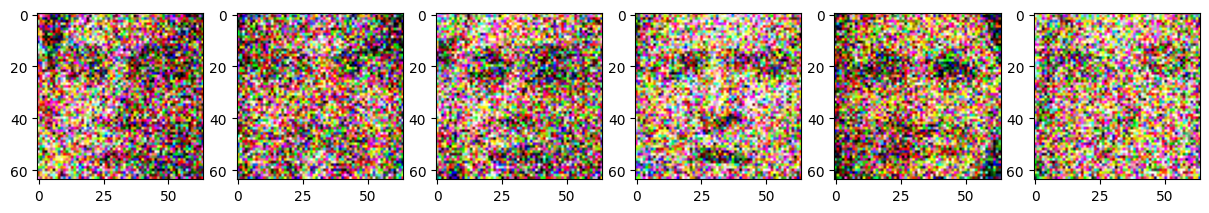

In [ ]:
perm = torch.randperm(X_tr_noisy.size(0))
idx = perm[:6]
samples = X_tr_noisy[idx].permute(0, 2, 3, 1).numpy()

plt.figure(figsize=(15,6))
for i, img in enumerate(samples):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img)
    plt.show

Я удивлюсь если из этого получится восстановить картинку )

Перепишем обучение под задачу чтобы

In [ ]:
def train(model, optim, loss_func, num_epochs, data_train, data_val, data_noise_train):
    to_show = next(iter(data_val))
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for X_tr, X_noise_tr in zip(data_train, data_noise_train):
            optimizer.zero_grad()
            X_tr = X_tr.to(device)
            X_noise_tr = X_noise_tr.to(device)
            reconstruction, latent_code = model(X_noise_tr) #зашумелнную картинку на вход модели
            loss = loss_func(reconstruction, X_tr) #чистую картинку на лосс функцию
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(data_train)
        train_losses.append(average_loss)

        model.eval()

        #думаю нам не очень интересен loss на валидации будем просто смотреть результат
      # #  running_loss = 0.0
      #   with torch.no_grad():
      #       for X_val in data_val:
      #           X_val = X_val.to(device)
      #           reconstruction, latent_code = model(X_val)
      #        #   loss = loss_func(reconstruction, X_val)

      #       #    running_loss += loss.item()

      #       average_loss = running_loss / len(data_val)
      #       val_losses.append(average_loss)

        with torch.no_grad():
            show_val, _ = model(to_show.to(device))


        # Вывод очищенных валидационных картинок
        show_val = show_val.detach().to('cpu')
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(to_show[i].numpy(), 0, 3))
            plt.title('Noisy Photo')

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(np.rollaxis(show_val[i].numpy(), 0, 3))
            plt.title('Noise_filtered Photo')


        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')





        # Построение графика
        plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
     #   plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()




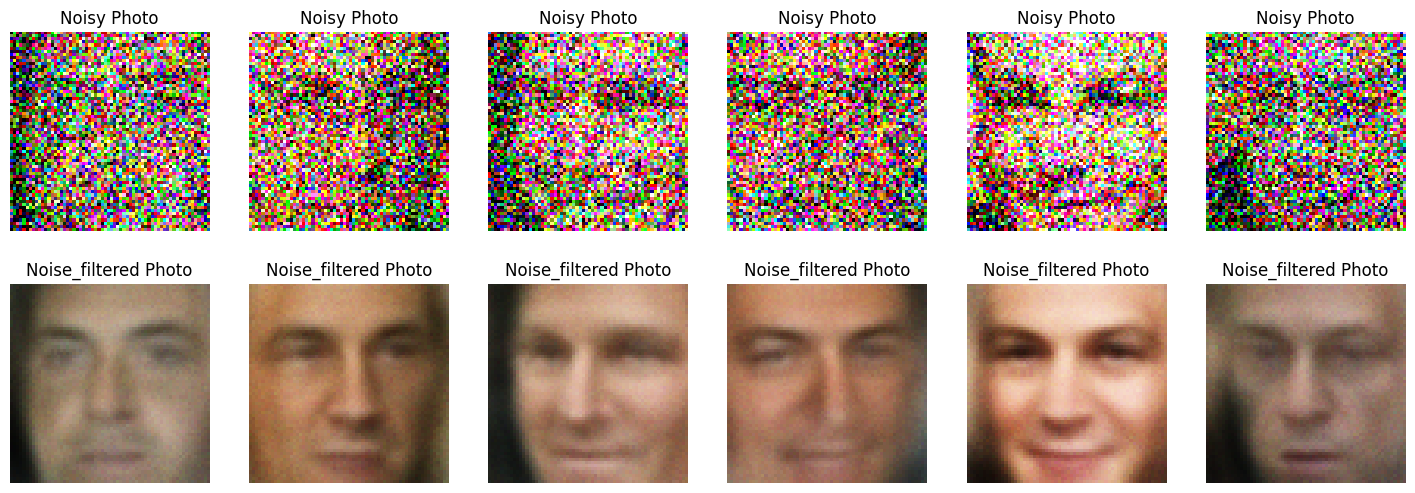

Epoch [20/20], Loss: 0.0045


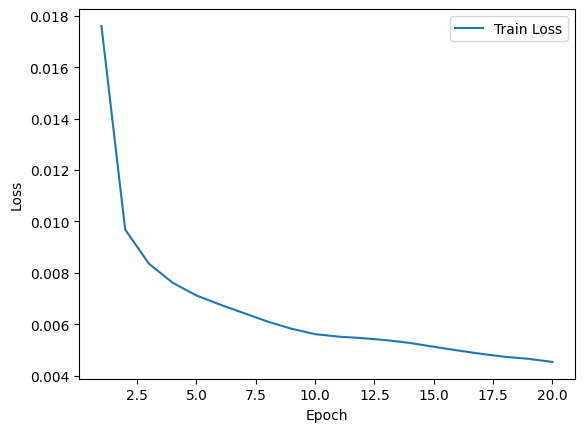

In [ ]:
auto_denoiser = Autoencoder().to(device)
optimizer = torch.optim.AdamW(auto_denoiser.parameters(), lr=0.0001)
train(auto_denoiser, optimizer, mse_loss, 20, tr_data, val_data, noisy_train)

Красота! Работает!

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>